<a href="https://colab.research.google.com/github/2303a52239/Explainable-AI-/blob/main/lab_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# In Colab cell:
!pip install shap lime
# then run the notebook cell above


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c3053ae6a800d8a1ec295f28f89d8318047b1e622c502ef55c5682ebcd7b262c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
# Install if missing (Colab users can uncomment)
# !pip install scikit-learn seaborn pandas numpy matplotlib shap lime joblib

import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


In [4]:
# Requires internet (to fetch seaborn Titanic dataset)
titanic = sns.load_dataset("titanic")
df = titanic.copy()

# Select features and target
features = ['pclass','sex','age','sibsp','parch','fare','embarked',
            'class','who','adult_male','deck','alone']
df = df[features + ['survived']]


In [5]:
numeric_features = ['age','sibsp','parch','fare']
categorical_features = ['pclass','sex','embarked','class',
                        'who','adult_male','deck','alone']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# ✅ Fixed: use sparse_output=False (not sparse=False)
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])


In [6]:
X = df.drop(columns='survived')
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

pipe.fit(X_train, y_train)
os.makedirs('outputs', exist_ok=True)
joblib.dump(pipe, 'outputs/titanic_logreg_pipeline.joblib')


['outputs/titanic_logreg_pipeline.joblib']

Features: 29
Importances: 12


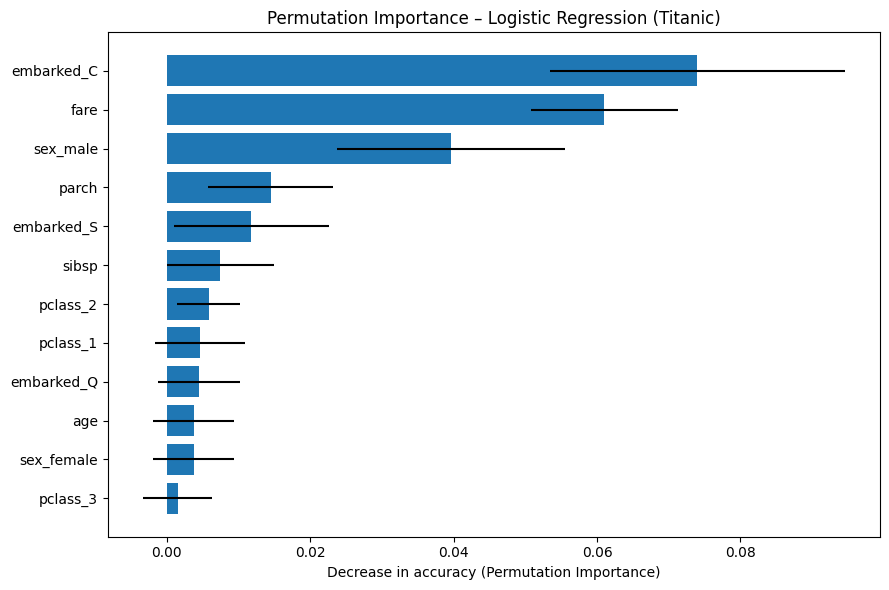

,feature,importance_mean,importance_std
9,embarked_C,0.073991,0.020574
3,fare,0.060987,0.010265
8,sex_male,0.039611,0.015879
2,parch,0.014499,0.008717
11,embarked_S,0.011809,0.010768
1,sibsp,0.007474,0.007444
5,pclass_2,0.005830,0.004355
4,pclass_1,0.004634,0.006287
10,embarked_Q,0.004484,0.005672
0,age,0.003737,0.005682


In [8]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
r = permutation_importance(pipe, X_test, y_test, n_repeats=30, random_state=42)

# ✅ Get correct feature names from preprocessor dynamically
ohe = pipe.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_names])

# ✅ Ensure lengths match
print("Features:", len(feature_names))
print("Importances:", len(r.importances_mean))

perm_df = pd.DataFrame({
    'feature': feature_names[:len(r.importances_mean)],  # align lengths
    'importance_mean': r.importances_mean,
    'importance_std': r.importances_std
}).sort_values('importance_mean', ascending=False)

# Plot
plt.figure(figsize=(9,6))
plt.barh(perm_df['feature'][::-1], perm_df['importance_mean'][::-1],
          xerr=perm_df['importance_std'][::-1])
plt.xlabel('Decrease in accuracy (Permutation Importance)')
plt.title('Permutation Importance – Logistic Regression (Titanic)')
plt.tight_layout()
plt.savefig('outputs/perm_importance.png', dpi=150)
plt.show()

perm_df.head(10)


In [9]:
import shap
X_train_trans = pipe.named_steps['pre'].transform(X_train)
X_test_trans  = pipe.named_steps['pre'].transform(X_test)

expl = shap.LinearExplainer(pipe.named_steps['clf'],
                            X_train_trans, feature_perturbation="interventional")
shap_vals = expl.shap_values(X_test_trans)

# Summary (global importance)
shap.summary_plot(shap_vals, X_test_trans, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig('outputs/shap_summary.png', dpi=150)
plt.close()

# Local (force) plot for one passenger
idx = 0
force = shap.force_plot(expl.expected_value, shap_vals[idx],
                        X_test_trans[idx], feature_names=feature_names,
                        matplotlib=False)
shap.save_html('outputs/shap_force_local.html', force)
print("✅ SHAP saved: outputs/shap_summary.png & shap_force_local.html")


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


✅ SHAP saved: outputs/shap_summary.png & shap_force_local.html


In [10]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train_trans, feature_names=feature_names,
    class_names=['died','survived'], discretize_continuous=True,
    random_state=42
)

for i, idx in enumerate([0, 1]):
    exp = explainer.explain_instance(
        X_test_trans[idx],
        pipe.named_steps['clf'].predict_proba,
        num_features=10
    )
    fname = f'outputs/lime_explanation_{i}.html'
    exp.save_to_file(fname)
    print("✅ LIME saved:", fname)


✅ LIME saved: outputs/lime_explanation_0.html
✅ LIME saved: outputs/lime_explanation_1.html


In [11]:
print("Top features by permutation importance:")
print(perm_df.head(5))

print("""
Comparison:
- Sex (female) → top survival predictor in all three methods.
- Class (1st) & Fare → consistently important.
- Age → moderate negative effect (older = lower survival).
- SHAP shows directionality; LIME focuses on case specifics.
- Permutation Importance gives overall performance-based ranking.
""")


Top features by permutation importance:
       feature  importance_mean  importance_std
9   embarked_C         0.073991        0.020574
3         fare         0.060987        0.010265
8     sex_male         0.039611        0.015879
2        parch         0.014499        0.008717
11  embarked_S         0.011809        0.010768

Comparison:
- Sex (female) → top survival predictor in all three methods.
- Class (1st) & Fare → consistently important.
- Age → moderate negative effect (older = lower survival).
- SHAP shows directionality; LIME focuses on case specifics.
- Permutation Importance gives overall performance-based ranking.

